## 2: Dataset2 3-Digit Classification

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

Shape: (84, 84)
Range: 0.0-1.0


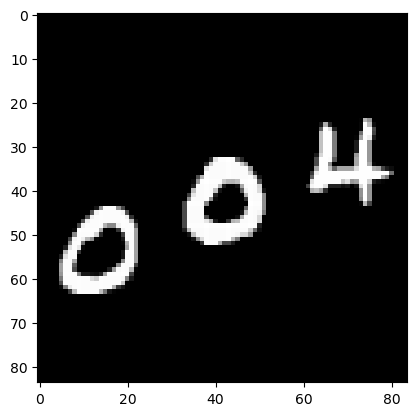

In [2]:
img = mpimg.imread('dataset2/triple_mnist/train/004/14_004.png')
imgplot = plt.imshow(img, cmap='gray')
print('Shape: ' + str(img.shape))
print('Range: ' + str(np.min(img)) + '-' + str(np.max(img)))

### Data Pre-Processing

In [20]:
import os

def get_data(subdir):
    # this imports all the data from a specified subdirectory and places into [img, label] pairs in a list.
    dir = 'dataset2/triple_mnist'  # base directory for all data.
    data = []
    labels = os.listdir(os.path.join(dir, subdir))  # get all folders (labels) in the subdirectory.
    
    for label in labels:  # cycles through each folder (label).
        class_num = int(label)

        for img in os.listdir(os.path.join(dir, subdir, label)):  # cycles through each png.
            try:
                img_arr = plt.imread(os.path.join(dir, subdir, label, img))  # reads image data.
                data.append([img_arr, class_num])  # appends image data with label.
            except Exception as e:
                print(e)

    return data


def get_some_data(num_imgs):
    # this imports num_imgs for each digit from 0-99.
    dir = 'dataset2/triple_mnist'  # base directory for all data.
    subdirs = ['train', 'val', 'test']
    data = []

    for subdir in subdirs:
        labels = os.listdir(os.path.join(dir, subdir))
        int_labels = [int(i) for i in labels]
        filtered_labels = [x for x in int_labels if x<100]
        
        for label in filtered_labels:
            for img in os.listdir(os.path.join(dir, subdir, "{:03d}".format(label)))[:num_imgs]:  # cycles through each png.
                try:
                    img_arr = plt.imread(os.path.join(dir, subdir, "{:03d}".format(label), img))  # reads image data.
                    data.append([img_arr, label])  # appends image data with label.
                except Exception as e:
                    print(e)
    
    return data

In [56]:
train_raw = get_data('train')
val_raw = get_data('val')
test_raw = get_data('test')

In [39]:
#combined_data = train_raw + val_raw + test_raw
combined_data = get_some_data(50)

In [40]:
def prop_split_data(data, labels, r_train, r_val, r_test):
    # this takes the combined data and randomly splits it into train, val, and test sets, each containing the right amount of each label.

    if r_train + r_val + r_test != 1:
        raise Exception("Ratios do not sum to 1.")

    train = []
    val = []
    test = []

    for lab in labels:
        isolated_data = [x for x in data if x[1]==lab]
        n = len(isolated_data)
        random.shuffle(isolated_data)

        train.extend(isolated_data[-(int(n*r_train)):])
        del isolated_data[-(int(n*r_train)):]
        val.extend(isolated_data[-(int(n*r_val)):])
        del isolated_data[-(int(n*r_val)):]
        test.extend(isolated_data[-(int(n*r_test)):])
        del isolated_data[-(int(n*r_test)):]

    return train, val, test

In [41]:
new_train, new_val, new_test = prop_split_data(combined_data, np.arange(0, 100), r_train=0.7, r_val=0.1, r_test=0.2)

In [42]:
def organise_data(data):
    # takes in data in shape (?,2), with each entry being in form [img, label].
    # converts label from int to one-hot array with correct index set to 1.
    X = []
    y = []

    for img, label in data:
        X.append(img)

        arr = np.zeros(100)
        arr[label] = 1  # correct index is set to 1.
        y.append(arr)

    return np.array(X), np.array(y)

In [53]:
X_train, y_train = organise_data(new_train)
X_test, y_test = organise_data(new_test)

### Xception Model

In [44]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.math import confusion_matrix

In [45]:
def new_model():

    model = Xception(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=(84, 84, 1),
        pooling='max',
        classes=100,
        classifier_activation='softmax'
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=categorical_crossentropy,
        metrics=['accuracy',
                'AUC',
                'Precision',
                'Recall']
    )

    model.summary()

    return model

In [46]:
model = new_model()
model_train = model.fit(
    x=X_train,
    y=y_train,
    epochs=10,
    shuffle=True,
    validation_split=0.2,
    verbose=1
)

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 84, 84, 1)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 41, 41, 32)           288       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 41, 41, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 41, 41, 32)           0         ['block1_conv1_bn[0][0]

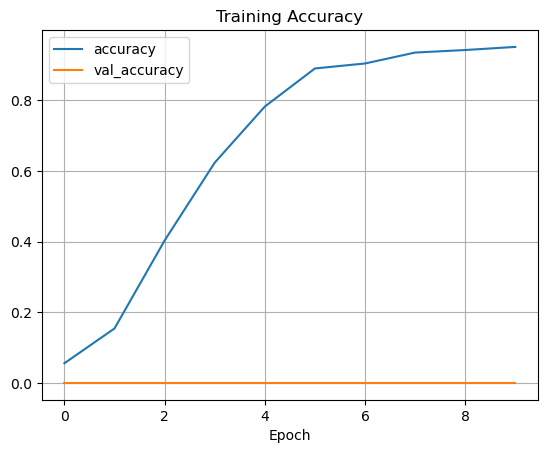

In [47]:
# EVALUATE TRAINING
train_perf = pd.DataFrame(model_train.history)
train_perf[['accuracy', 'val_accuracy']].plot()
plt.xlabel('Epoch')
plt.title('Training Accuracy')
plt.grid()
plt.show()

In [54]:
model_test = model.evaluate(
    x=X_test,
    y=y_test,
    verbose=1
    )

print(model.metrics_names)
print(model_test)

32/32 [==============================] - 11s 293ms/step - loss: 7.5848 - accuracy: 0.5450 - auc: 0.8387 - precision: 0.5631 - recall: 0.5400
['loss', 'accuracy', 'auc', 'precision', 'recall']
[7.584794044494629, 0.5450000166893005, 0.8387320637702942, 0.5630865693092346, 0.5400000214576721]


In [57]:
# EVALUATE TESTING
def postprocess(array):
    output = []
    for row in range(0,len(array)):
        idx = np.argmax(array[row,:])
        output.append(idx)

    return output

y_pred = model.predict(
    x=X_test,
    verbose=1
    )

32/32 [==============================] - 12s 369ms/step
tf.Tensor(
[[10  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]], shape=(100, 100), dtype=int32)


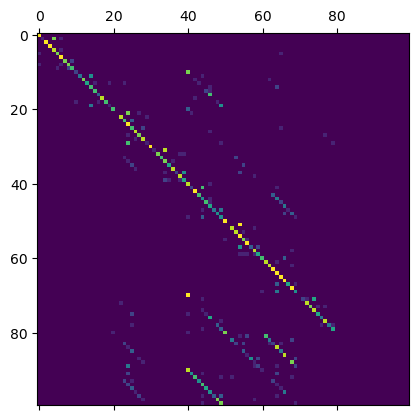

In [62]:
conf_mat = confusion_matrix(
    labels=postprocess(y_test),
    predictions=postprocess(y_pred),
    num_classes=100
)

plt.matshow(conf_mat)